# Self-Driving Car Engineer Nanodegree


## Project 5: Vehicle Detection and Tracking


---
## Step 0: Import Libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import time
import zipfile
import os
from PIL import Image
import itertools
import pickle
from sklearn.svm import SVC


---

## Step 1: Unzip the training images


In [2]:
ENABLE_UNZIP = False

def unzip (path_to_zip_file,directory_to_extract_to):
    zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
    zip_ref.extractall(directory_to_extract_to)
    zip_ref.close()

if ENABLE_UNZIP == True:
    if not os.path.exists("./train_images"):
        os.mkdir("./train_images")
    unzip("../non-vehicles.zip","./train_images")
    unzip("../vehicles.zip","./train_images")

----

## Step 2: Functions definition


### 1) Color and HOG functions

In [86]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist_visualize(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_Color_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True,visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_HOG_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        if np.max(image)>1:
            image = image.astype(np.float32)/255
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        if np.max(feature_image)>1:
            print("1 - Pixel maior que 1")
            image = image.astype(np.float32)/255
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
        
    #if np.max(feature_image) >1:
        #print("2 - Pixel maior que 1")
        #feature_image = feature_image.astype(np.float32)/255
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


### 2) Sliding window functions

In [4]:
# Here is your draw_boxes function
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #print(np.max(test_features))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

### 4) Dealing with false positives ans multiple windows functions

In [5]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,1), 6)
    # Return the image
    return img




## Step 2: Test each part in the pipe line

----

## Step 3: Train the SVM 


### 1) Overview of the sample images

We can verify that the amount of images is equilibrate, once the total of vehicles images is very close to the the total of images of non-vehicle images. Therefore, it is reasonable to use all these images for training and test the SVM.

In [6]:
#Count the number of elements in the folder


def count_num_files (path,enable_print = True):
    #List all the directories inside the folder in path
    list = os.listdir(path)
    #Verify in each inner folder
    num_elements_=[]
    dir_folder_ = []
    total_elements  = 0
    for folder_name in list:
        if folder_name[0] != '.':
            dir_folder = path + folder_name
            num_elements = len(os.listdir(dir_folder))
            num_elements_.append(num_elements)
            dir_folder_.append(dir_folder)
            total_elements += num_elements
            if enable_print ==True:
                print (folder_name,": ",str(num_elements),'elements')
    if enable_print == True:
        print("TOTAL: ",str(total_elements ),"elements")
    return num_elements_,dir_folder_

ENABLE_MANUALLY_DATA = True
if ENABLE_MANUALLY_DATA == True:
    path_vehicles= "./train_images_manually/vehicles/"
    path_non_vehicles= "./train_images_manually/non-vehicles/"
else:
    path_vehicles= "./train_images/vehicles/"
    path_non_vehicles= "./train_images/non-vehicles/"

path_non_vehicles= "./train_images/non-vehicles/"
print("VEHICLE IMAGES:")
num_vehicles,dir_vehicles = count_num_files(path_vehicles);
print("\r\nNON-VEHICLE IMAGES:")
num_non_vehicles,dir_non_vehicles = count_num_files(path_non_vehicles);



VEHICLE IMAGES:
GTI_Far :  163 elements
GTI_Left :  134 elements
GTI_MiddleClose :  71 elements
GTI_Right :  125 elements
KITTI_extracted :  5967 elements
TOTAL:  6460 elements

NON-VEHICLE IMAGES:
Extras :  5074 elements
GTI :  3901 elements
TOTAL:  8975 elements



### 2) Test and vizualize each feature

In [13]:
#--------------------
#1) IMPORT THE IMAGES
#--------------------

#Vehicle images
cars = []
for dir in dir_vehicles:
    images = glob.glob(dir+"/*.png")
    for image in images:
        cars.append(image)

#Non-vehicle images
notcars = []
for dir in dir_non_vehicles:
    images = glob.glob(dir+"/*.png")
    for image in images:
        notcars.append(image)

print("Number of vehicle images:",len(cars))
print("Number of non-vehicle images:",len(notcars))

Number of vehicle images: 6459
Number of non-vehicle images: 8973



#### 2.1) HOG feature


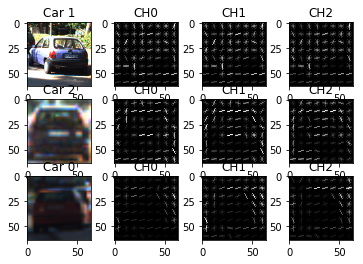

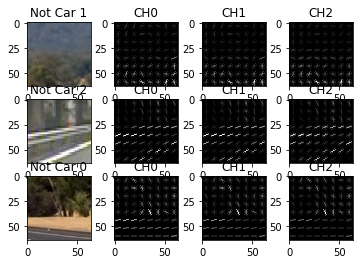

In [58]:
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel='ALL'

i = 1
plt.figure()
num_dir = np.random.uniform(low=0, high=len(cars), size=3).astype(np.int)
for num in num_dir:
    feature_image = mpimg.imread(cars[num])
    plt.subplot(3, 4, i)
    plt.imshow(feature_image)
    plt.title("Car "+str(i%3))
    i += 1
    # Calculate the HOG feature
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            features, hog_image  = get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=True, feature_vec=True)   
            plt.subplot(3, 4, i)
            i += 1
            plt.imshow(hog_image, cmap='gray')
            plt.title('CH'+str(channel))
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=True, feature_vec=True)

 
i = 1
plt.figure()
num_dir = np.random.uniform(low=0, high=len(cars), size=3).astype(np.int)
for num in num_dir:
    feature_image = mpimg.imread(notcars[num])
    plt.subplot(3, 4, i)
    plt.imshow(feature_image)
    plt.title("Not Car "+str(i%3))
    i += 1
    # Calculate the HOG feature
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            features, hog_image  = get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=True, feature_vec=True)   
            plt.subplot(3, 4, i)
            i += 1
            plt.imshow(hog_image, cmap='gray')
            plt.title('CH'+str(channel))
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=True, feature_vec=True)




#### 2.2) Spatial feature


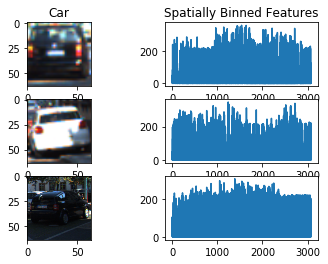

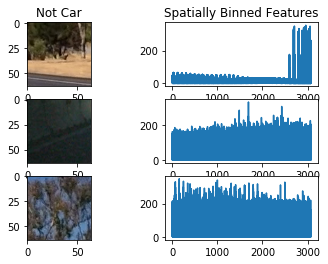

In [129]:
#CAR images
num_dir = np.random.uniform(low=0, high=len(cars), size=3).astype(np.int)
i  =1
color_space='HLS'

plt.figure()
for num in num_dir:
    
    img = mpimg.imread(cars[num])

    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
           
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img) 
        
    plt.subplot(3, 2, i)
    plt.imshow(img)
    if(i<3):
        plt.title("Car")
    i += 1
    feature_vec = bin_spatial(feature_image, size=(32, 32))
    plt.subplot(3, 2, i)
    i += 1
    plt.plot(feature_vec)
    if(i<=3):
        plt.title('Spatially Binned Features')

#NOT CAR images
num_dir = np.random.uniform(low=0, high=len(cars), size=3).astype(np.int)
i  =1
color_space='HLS'
plt.figure()
for num in num_dir:
    img = mpimg.imread(notcars[num])
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(feature_image) 
        
    plt.subplot(3, 2, i)
    plt.imshow(img)
    if(i<3):
        plt.title("Not Car")
    i += 1
    feature_vec = bin_spatial(feature_image, size=(32, 32))
    plt.subplot(3, 2, i)
    i += 1
    plt.plot(feature_vec)
    if(i<=3):
        plt.title('Spatially Binned Features')



#### 2.3) Histogram feature


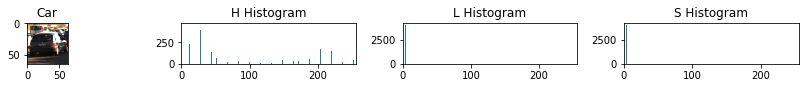

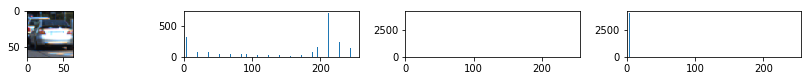

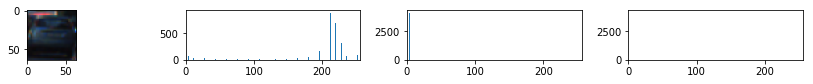

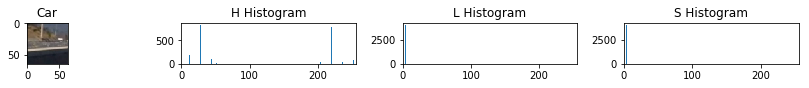

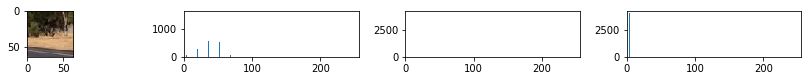

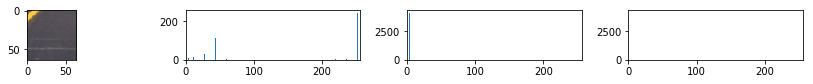

In [134]:
#CAR images
num_dir = np.random.uniform(low=0, high=len(cars), size=3).astype(np.int)
hist_bins=32
i  =1
color_space='HLS'

plt.figure()
for num in num_dir:
    fig = plt.figure(figsize=(12,3))
    img = mpimg.imread(cars[num])
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)  
    
    plt.subplot(3, 4, i)
    i += 1
    plt.imshow(img)
    if(i<5):
        plt.title("Car")
    
    rh, gh, bh, bincen, feature_vec = color_hist_visualize(feature_image, nbins=hist_bins)

    plt.subplot(3, 4, i)
    i += 1
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    if(i<5):
        plt.title('H Histogram')
    
    plt.subplot(3, 4, i)
    i += 1
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    if(i<5):
        plt.title('L Histogram')
    plt.subplot(3, 4, i)
    i += 1
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    if(i<6):
        plt.title('S Histogram')
    fig.tight_layout()

#CAR images
num_dir = np.random.uniform(low=0, high=len(cars), size=3).astype(np.int)
hist_bins=32
i  =1
color_space='HLS'

plt.figure()
for num in num_dir:
    fig = plt.figure(figsize=(12,3))
    img = mpimg.imread(notcars[num])
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)  
    
    plt.subplot(3, 4, i)
    i += 1
    plt.imshow(img)
    if(i<5):
        plt.title("Car")
    
    rh, gh, bh, bincen, feature_vec = color_hist_visualize(feature_image, nbins=hist_bins)

    plt.subplot(3, 4, i)
    i += 1
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    if(i<5):
        plt.title('H Histogram')
    
    plt.subplot(3, 4, i)
    i += 1
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    if(i<5):
        plt.title('L Histogram')
    plt.subplot(3, 4, i)
    i += 1
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    if(i<6):
        plt.title('S Histogram')
    fig.tight_layout()


### 2) Training the SVM

In [14]:
#-----------------------
#2) EXTRACT THE FEATURES
#-----------------------
#Parameters
color_space='HLS'
spatial_size=(32,32)
hist_bins=32
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel='ALL'
spatial_feat=True
hist_feat=True
hog_feat=True
MAX_NUM_SAMPLES_NV =None
MAX_NUM_SAMPLES_V =None
#For img in cars:
count = 0
car_features = []
for directory in cars:
    img = mpimg.imread(directory)
    if np.max(img)>1:
        img = image_sample.astype(np.float32)/255
    features = single_img_features(img, color_space, spatial_size,
                            hist_bins, orient, 
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_feat, hist_feat, hog_feat)
    car_features.append(features)
    if count==MAX_NUM_SAMPLES_V and MAX_NUM_SAMPLES_V!=None:
        break
    count+=1


#For img in non cars:
count = 0
notcar_features = []
for directory in notcars:
    img = mpimg.imread(directory)
    if np.max(img)>1:
        img = img.astype(np.float32)/255
        print("Maximo maior que 1")
    features = single_img_features(img, color_space, spatial_size,
                            hist_bins, orient, 
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_feat, hist_feat, hog_feat)
    notcar_features.append(features)
    if count==MAX_NUM_SAMPLES_NV and MAX_NUM_SAMPLES_NV!=None:
        break
    count+=1


print("Number of Vehicle features:",str(len(car_features)))
print("Number of non-Vehicle features:",str(len(notcar_features)))

Number of Vehicle features: 6459
Number of non-Vehicle features: 8973


In [ ]:
#----------------
#2) TRAIN THE SVM
#----------------

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)


# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 

C=1.0
gama = 0.7
svc = SVC(kernel = 'linear', gamma=gama, C=C)
#svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

#save the SVM in a pickle file

dist_pickle = { "svc": svc, "scaler": X_scaler,"color_space":color_space,"spatial_size":spatial_size
              ,"hist_bins":hist_bins,"orient":orient,"pix_per_cell":pix_per_cell,"cell_per_block":cell_per_block
              ,"hog_channel":hog_channel
              ,"spatial_feat":spatial_feat,"hist_feat":hist_feat,"hog_feat":hog_feat}
pickle.dump( dist_pickle, open( "svc_pickle4.p", "wb" ) )

----

## Step 4: Test the algorithm in sample images

C:\Users\daniy\AppData\Local\Continuum\anaconda3\envs\carnd-term1\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator StandardScaler from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\daniy\AppData\Local\Continuum\anaconda3\envs\carnd-term1\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator SVC from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


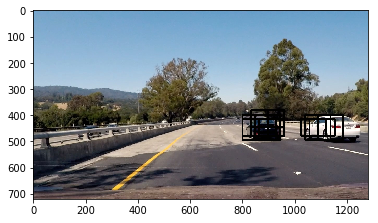

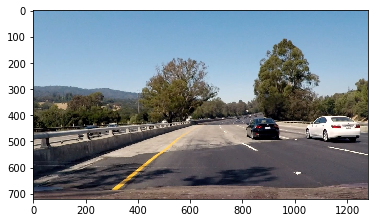

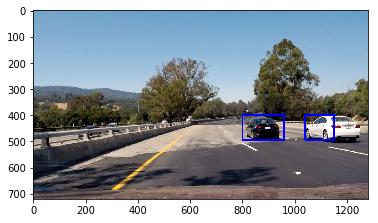

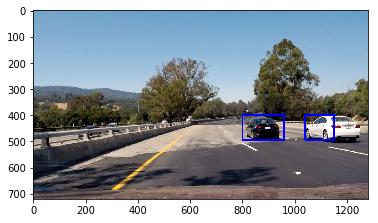

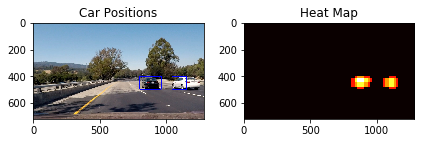

In [145]:
from scipy.ndimage.measurements import label
show_image = True
dir_test_img = "./test_images/test4.jpg"
y_start_stops =[]
y_start_stops.append([350, 500]) # Min and max in y to search in slide_window()
y_start_stops.append([400, 500]) # Min and max in y to search in slide_window()
y_start_stops.append([450, 600]) # Min and max in y to search in slide_window()
y_start_stops.append([400, 700]) # Min and max in y to search in slide_window()
y_start_stops.append([400, 700]) # Min and max in y to search in slide_window()

x_start_stop=[800, 1280]

size_windows = []
size_windows.append(64)
size_windows.append(96)
size_windows.append(120)
size_windows.append(180)
size_windows.append(232)
image_sample = mpimg.imread(dir_test_img)
if np.max(image_sample)>1:
    image_sample = image_sample.astype(np.float32)/255

    

    
def find_windows(image_sample,svc,X_scaler,color_space,hist_bins,spatial_size,orient,pix_per_cell,
                 cell_per_block,hog_channel,spatial_feat,hist_feat,hog_feat,
                 y_start_stops,x_start_stop,size_windows):
    
    hot_windows = []

    for size_window,y_start_stop in zip(size_windows,y_start_stops):
        windows =  slide_window(image_sample, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=(size_window, size_window),xy_overlap=(0.5, 0.5))
        h = search_windows(image_sample, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)    

        hot_windows.append(h)
        
    hot_windows = list(itertools.chain(*hot_windows))
    return hot_windows

pickle_file = "svc_pickle2.p"
# load a pe-trained svc model from a serialized (pickle) file
dist_pickle = pickle.load( open(pickle_file, "rb" ) )

# get attributes of our svc object
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
color_space =dist_pickle["color_space"]
hist_bins =dist_pickle["hist_bins"]
spatial_size =dist_pickle["spatial_size"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
hog_channel = dist_pickle["hog_channel"]
spatial_feat = dist_pickle["spatial_feat"]
hist_feat = dist_pickle["hist_feat"]
hog_feat = dist_pickle["hog_feat"]

hot_windows= find_windows(image_sample,svc,X_scaler,color_space,hist_bins,spatial_size,orient,pix_per_cell,
                 cell_per_block,hog_channel,spatial_feat,hist_feat,hog_feat,
                 y_start_stops,x_start_stop,size_windows)

heat = np.zeros_like(image_sample[:,:,0]).astype(np.float)
heat = add_heat(heat,hot_windows)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image_sample), labels)

if show_image == True:
    #window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6) 
    draw_image = np.copy(image_sample)
    window_img = draw_boxes(draw_image, hot_windows, color=(255, 255, 0), thick=6)  
    plt.figure()
    plt.imshow(window_img)# Add heat to each box in box list
    plt.figure()
    plt.imshow(image_sample)
    plt.figure()
    plt.imshow(draw_img)
    
plt.figure()
plt.imshow(draw_img)


fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


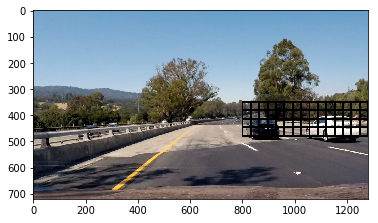

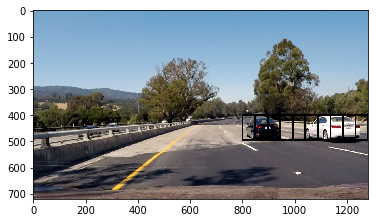

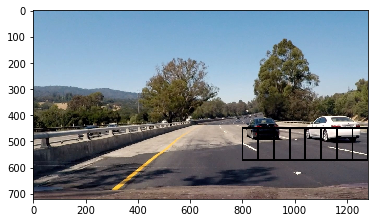

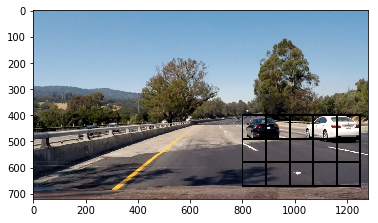

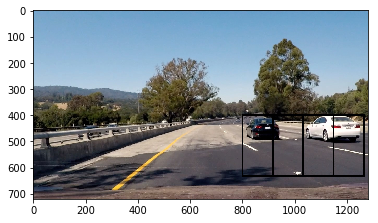

In [144]:
for i in range(5):
    windows =  slide_window(image_sample, x_start_stop, y_start_stops[i], 
                            xy_window=(size_windows[i], size_windows[i]),xy_overlap=(0.5, 0.5))
    window_img = draw_boxes(image_sample, windows, color=(0, 0, 255), thick=6)                    
    plt.figure()
    plt.imshow(window_img)

In [12]:

#Input parameters
MAX_NUM_ITER = None
show_image = False
back_frame_num = 6
y_start_stops =[]
y_start_stops.append([350, 500]) # Min and max in y to search in slide_window()
y_start_stops.append([400, 500]) # Min and max in y to search in slide_window()
y_start_stops.append([450, 600]) # Min and max in y to search in slide_window()
y_start_stops.append([400, 700]) # Min and max in y to search in slide_window()
y_start_stops.append([400, 700]) # Min and max in y to search in slide_window()

x_start_stop=[800, 1280]

size_windows = []
size_windows.append(64)
size_windows.append(96)
size_windows.append(120)
size_windows.append(180)
size_windows.append(232)
image_sample = mpimg.imread(dir_test_img)

pickle_file = "svc_pickle2.p"

# load a pe-trained svc model from a serialized (pickle) file
dist_pickle = pickle.load( open(pickle_file, "rb" ) )

# get attributes of our svc object
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
color_space =dist_pickle["color_space"]
hist_bins =dist_pickle["hist_bins"]
spatial_size =dist_pickle["spatial_size"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
hog_channel = dist_pickle["hog_channel"]
spatial_feat = dist_pickle["spatial_feat"]
hist_feat = dist_pickle["hist_feat"]
hog_feat = dist_pickle["hog_feat"]

#Read the frames of the video
VideoPath = './project_video.mp4'
video = cv2.VideoCapture(VideoPath)
countFrames = 0
video.set(cv2.CAP_PROP_POS_FRAMES,countFrames)

ret, frame =video.read()

'''
cv2.imwrite('frame.png',frame)
frame = frame.astype(np.float32)/255
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
print(np.max(frame))
print(frame[0][0][:])
frame2 = mpimg.imread('frame.png')
print(np.max(frame2))
print(frame2[0][0][:])
'''
#MOSTRAR RESUMO DO VIDEO
print("===========================================================")
print("Frame Shape:",frame.shape)
TotalFrames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
print("Total de frames:",TotalFrames)
print("FPS: ",int(video.get(cv2.CAP_PROP_FPS)))
print("===========================================================")


#name of the output video
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
video_out =cv2.VideoWriter('result4_thr10.mp4',fourcc,video.get(cv2.CAP_PROP_FPS), (frame.shape[1],frame.shape[0]))


while(ret == True):
    frame = frame.astype(np.float32)/255
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    hot_windows= find_windows(frame,svc,X_scaler,color_space,hist_bins,spatial_size,orient,pix_per_cell,
                 cell_per_block,hog_channel,spatial_feat,hist_feat,hog_feat,
                 y_start_stops,x_start_stop,size_windows)
    
    if (countFrames%back_frame_num) == 0:
        heat = np.zeros_like(frame[:,:,0]).astype(np.float)
    
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(frame), labels)
    draw_img = np.uint8(draw_img*255)
    draw_img = cv2.cvtColor(draw_img,cv2.COLOR_RGB2BGR)
    
    video_out.write(draw_img)
    countFrames = countFrames +1
    print(str(countFrames),"/",str(TotalFrames))
    
    if show_image == True:
        #window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6) 
        draw_image = np.copy(frame)
        window_img = draw_boxes(draw_image, hot_windows, color=(255, 255, 0), thick=6)  
        plt.figure()
        plt.imshow(window_img)# Add heat to each box in box list
        plt.figure()
        plt.imshow(image_sample)
        plt.figure()
        plt.imshow(draw_img)
    
    if MAX_NUM_ITER != None:
        if (countFrames == MAX_NUM_ITER):
            break
            
    #read next frame
    ret, frame =video.read()
    
    
#Save the video
video_out.release() 
video.release()

print("END")
#'''

C:\Users\daniy\AppData\Local\Continuum\anaconda3\envs\carnd-term1\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator StandardScaler from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\daniy\AppData\Local\Continuum\anaconda3\envs\carnd-term1\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator SVC from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Frame Shape: (720, 1280, 3)
Total de frames: 1260
FPS:  25
1 / 1260
2 / 1260
3 / 1260
4 / 1260
5 / 1260
6 / 1260
7 / 1260
8 / 1260
9 / 1260
10 / 1260
11 / 1260
12 / 1260
13 / 1260
14 / 1260
15 / 1260
16 / 1260
17 / 1260
18 / 1260
19 / 1260
20 / 1260
21 / 1260
22 / 1260
23 / 1260
24 / 1260
25 / 1260
26 / 1260
27 / 1260
28 / 1260
29 / 1260
30 / 1260
31 / 1260
32 / 1260
33 / 1260
34 / 1260
35 / 1260
36 / 1260
37 / 1260
38 / 1260
39 / 1260
40 / 1260
41 / 1260
42 / 1260
43 / 1260
44 / 1260
45 / 1260
46 / 1260
47 / 1260
48 / 1260
49 / 1260
50 / 1260
51 / 1260
52 / 1260
53 / 1260
54 / 1260
55 / 1260
56 / 1260
57 / 1260
58 / 1260
59 / 1260
60 / 1260
61 / 1260
62 / 1260
63 / 1260
64 / 1260
65 / 1260
66 / 1260
67 / 1260
68 / 1260
69 / 1260
70 / 1260
71 / 1260
72 / 1260
73 / 1260
74 / 1260
75 / 1260
76 / 1260
77 / 1260
78 / 1260
79 / 1260
80 / 1260
81 / 1260
82 / 1260
83 / 1260
84 / 1260
85 / 1260
86 / 1260
87 / 1260
88 / 1260
89 / 1260
90 / 1260
91 / 1260
92 / 1260
93 / 1260
94 / 1260
95 / 1260


740 / 1260
741 / 1260
742 / 1260
743 / 1260
744 / 1260
745 / 1260
746 / 1260
747 / 1260
748 / 1260
749 / 1260
750 / 1260
751 / 1260
752 / 1260
753 / 1260
754 / 1260
755 / 1260
756 / 1260
757 / 1260
758 / 1260
759 / 1260
760 / 1260
761 / 1260
762 / 1260
763 / 1260
764 / 1260
765 / 1260
766 / 1260
767 / 1260
768 / 1260
769 / 1260
770 / 1260
771 / 1260
772 / 1260
773 / 1260
774 / 1260
775 / 1260
776 / 1260
777 / 1260
778 / 1260
779 / 1260
780 / 1260
781 / 1260
782 / 1260
783 / 1260
784 / 1260
785 / 1260
786 / 1260
787 / 1260
788 / 1260
789 / 1260
790 / 1260
791 / 1260
792 / 1260
793 / 1260
794 / 1260
795 / 1260
796 / 1260
797 / 1260
798 / 1260
799 / 1260
800 / 1260
801 / 1260
802 / 1260
803 / 1260
804 / 1260
805 / 1260
806 / 1260
807 / 1260
808 / 1260
809 / 1260
810 / 1260
811 / 1260
812 / 1260
813 / 1260
814 / 1260
815 / 1260
816 / 1260
817 / 1260
818 / 1260
819 / 1260
820 / 1260
821 / 1260
822 / 1260
823 / 1260
824 / 1260
825 / 1260
826 / 1260
827 / 1260
828 / 1260
829 / 1260
830 / 1260

In [ ]:


#Read the frames of the video
VideoPath = './result4.mp4
video = cv2.VideoCapture(VideoPath)

ret, frame =video.read()

#MOSTRAR RESUMO DO VIDEO
print("===========================================================")
print("Frame Shape:",frame.shape)
TotalFrames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
print("Total de frames:",TotalFrames)
print("FPS: ",int(video.get(cv2.CAP_PROP_FPS)))
print("===========================================================")


#name of the output video
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
video_out =cv2.VideoWriter('result4_v1.mp4',fourcc,video.get(cv2.CAP_PROP_FPS), (frame.shape[1],frame.shape[0]))
countFrames = 0
while(ret == True):

    frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)
    video_out.write(frame)

    countFrames = countFrames +1
    print(str(countFrames),"/",str(TotalFrames))
    
    if MAX_NUM_ITER != None:
        if (countFrames > MAX_NUM_ITER):
            break
            
    #read next frame
    ret, frame =video.read()
    
    
#Save the video
video_out.release() 
video.release()

print("END")
#'''

In [ ]:
VideoPath = '../result3.mp4'
video = cv2.VideoCapture(VideoPath)


Numframe = 500
video.set(cv2.CAP_PROP_POS_FRAMES,Numframe)
ret, frame =video.read()
#Define thresholds max and min for binary image construction
l_thresh_min = 0
l_thresh_max = 255
thresh_min = 45
thresh_max = 100
s_thresh_min = 170
s_thresh_max = 255
#Creating binary image
color_binary,combined_binary =CreateBinaryImage(img,thresh_min,thresh_max,s_thresh_min,s_thresh_max)
plt.figure()
plt.imshow(frame)
plt.figure()
plt.imshow(combined_binary)
